## Ablation studies

Ablation studies ma swoje korzenie w neurobiologi, gdzie analizuje się złożone struktury takie jak mózg poprzez usuwanie ich fragmentu a następnie analizowanie zmian w sposobie pracy. Analogicznie działa to w analizie sieci neuronowych - wyłącza lub modyfikuje się fragment sieci a następnie mierzy zmiany w otrzymywanych wynikach. W ten sposób jesteśmy w stanie oszacować funkcję danego segmentu sieci oraz jej wpływ na jakość wyników, co może pozwolić na dodatkową jej optymalizację.

*Źródło: [Richard Meyes, Melanie Lu, Constantin Waubert de Puiseau, Tobias Meisen "Ablation Studies in Artificial Neural Networks", arXiv:1901.08644 [cs.NE]](https://arxiv.org/abs/1901.08644)*


## Analizowana sieć

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import random as rn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
np.random.seed(23)
rn.seed(1112)
tensorflow.random.set_seed(89)

**Przygotowanie danych**

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


**Budowa modelu**

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

**Trening**

In [5]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 14s 33ms/step - loss: 0.7751 - accuracy: 0.7575 - val_loss: 0.0818 - val_accuracy: 0.9792
Epoch 2/10
422/422 [==============================] - 14s 33ms/step - loss: 0.1266 - accuracy: 0.9607 - val_loss: 0.0568 - val_accuracy: 0.9850
Epoch 3/10
422/422 [==============================] - 13s 32ms/step - loss: 0.0880 - accuracy: 0.9731 - val_loss: 0.0443 - val_accuracy: 0.9887
Epoch 4/10
422/422 [==============================] - 14s 33ms/step - loss: 0.0759 - accuracy: 0.9766 - val_loss: 0.0425 - val_accuracy: 0.9895
Epoch 5/10
422/422 [==============================] - 14s 33ms/step - loss: 0.0632 - accuracy: 0.9803 - val_loss: 0.0364 - val_accuracy: 0.9917
Epoch 6/10
422/422 [==============================] - 14s 33ms/step - loss: 0.0578 - accuracy: 0.9820 - val_loss: 0.0339 - val_accuracy: 0.9912
Epoch 7/10
422/422 [==============================] - 14s 33ms/step - loss: 0.0515 - accuracy: 0.9841 - val_loss: 0.0338 - val_accuracy:

**Ewaluacja**

c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


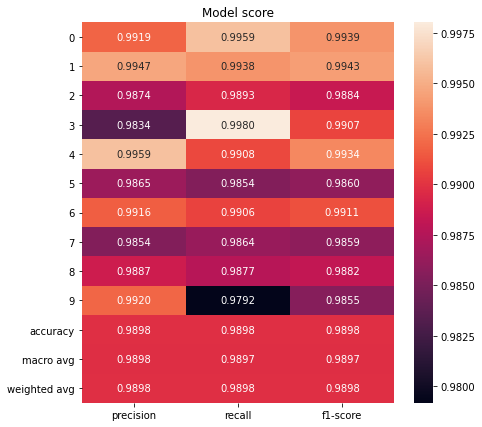

In [6]:
# Convert one-hot to index
Y_test = np.argmax(y_test, axis=1) 
y_pred = model.predict_classes(x_test)

# Evaluate the model
clf_orig_report = classification_report(Y_test, y_pred, output_dict=True)
clf_orig_data = pd.DataFrame(clf_orig_report).iloc[:-1, :].T

# Create a heatmap
fig, ax = plt.subplots(figsize=[7, 7])
sns.heatmap(clf_orig_data, annot=True, fmt=".4f", ax=ax)
ax.set_title('Model score')
plt.show()

*Źródło: https://keras.io/examples/vision/mnist_convnet/*

## Badanie wpływu zmian na model

### Przygotowanie funkcji pomocniczych

In [14]:
def evaluate(model):
    # Evaluate the model
    y_pred = model.predict_classes(x_test)
    clf_report = classification_report(Y_test, y_pred, output_dict=True)
    clf_data = pd.DataFrame(clf_report).iloc[:-1, :].T
    
    # Display score heatmap
    fig, ax = plt.subplots(1, 2, figsize=[16, 7])
    sns.heatmap(clf_data, annot=True, fmt=".4f", ax=ax[0])
    ax[0].set_title('Model score')
    
    # Display difference heatmap
    clf_diff = clf_data.subtract(clf_orig_data)
    cmap = sns.diverging_palette(10, 240, as_cmap=True)
    sns.heatmap(clf_diff, annot=True, fmt=".4f", ax=ax[1], cmap=cmap, center=0.00)
    ax[1].set_title('Model difference')
    
    plt.show()

### Usunięcie drugiej warstwy MaxPooling

c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


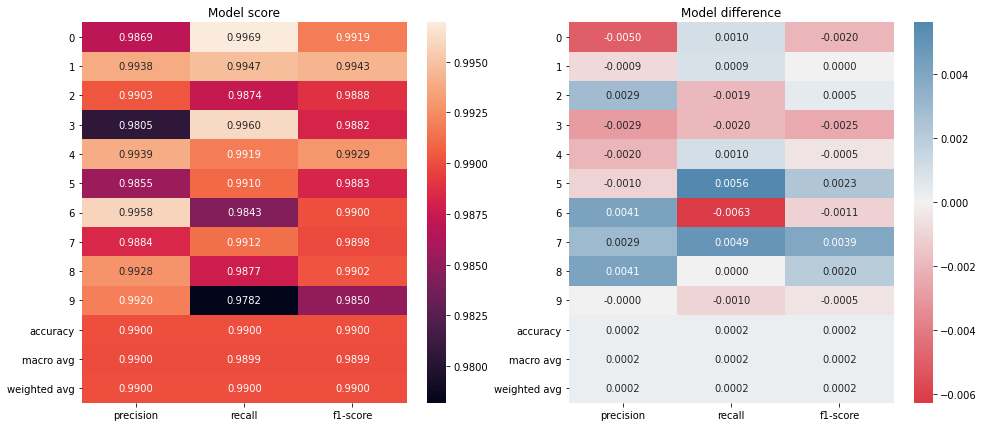

In [31]:
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model1.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1, verbose=0)
evaluate(model1)

Ogólna jakość modelu zmieniła się nie znacznie, jednak widzimy że dla poszczególnych klas zmiany te są już znaczące. Należy podkreślić, że klasy dla których jakość predykcji się polepszyła nie są stałe, i zmieniają się przy ponownym uruchomieniu treningu. Warto także zauważyć że, o ile średnia wartość precyzji nie uległa znacznej zmianie, to wartość dla najgorszej klasy jest znacznie niższa. Obserwujemy zatem działanie "stabilizujące" tej warstwy.

### Usunięcie drugiej warstwy konwolucyjnej razem z MaxPooling

c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


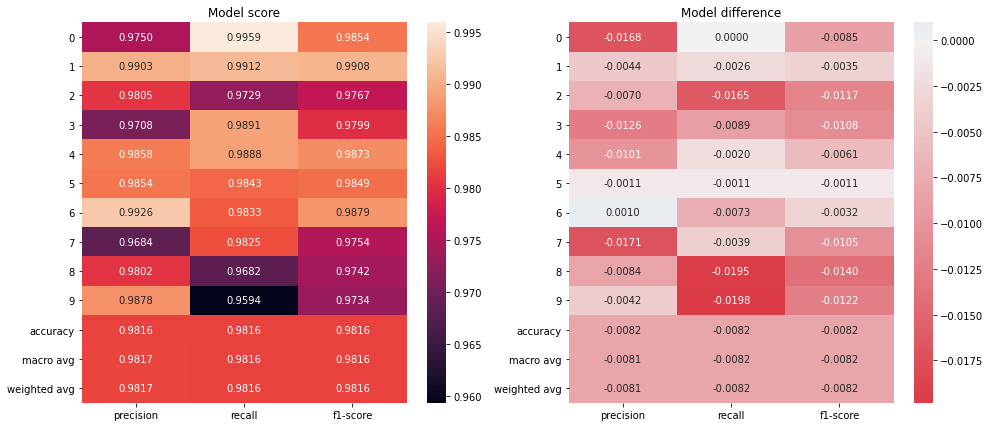

In [17]:
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1, verbose=0)
evaluate(model2)

Tak jak można się było tego spodziewać, widać bardzo duży spadek jakości sieci. To co ukazuje się po wielokrotnym przetestowaniu sieci to to, że nie wpływa to na wszystkie klasy równomiernie. Największe pogorszenie jakości widać na `2`, `8`, i `9`, a najmniejszą różnicę dla `5`.

### Zmiana funkcji aktywacyjnej na sigmoid

c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


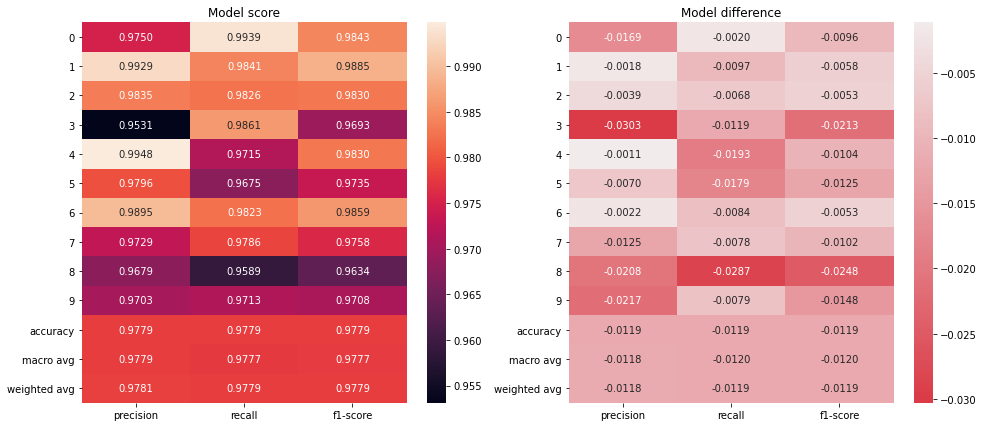

In [22]:
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1, verbose=0)
evaluate(model3)

Przy zmianie funkcji aktywacyjnej na sigmoid widać bardzo duże pogorszenie jakości sieci, jeszcze większe niż w przypadku usunięcia drugiej warstwy konwolucyjnej. Przy wielokrotnym powtórzeniu eksperymentu znowu okazuje się że w przypadku `8` i `9` różnica jest największa. To samo dotyczy się `3`, czego nie było widać w poprzednim eskperymencie. Można zatem wnioskować że `2`, `3` a w sczególności `8` i `9` są trudne do rozpoznania.

### Zmiana batch size

c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


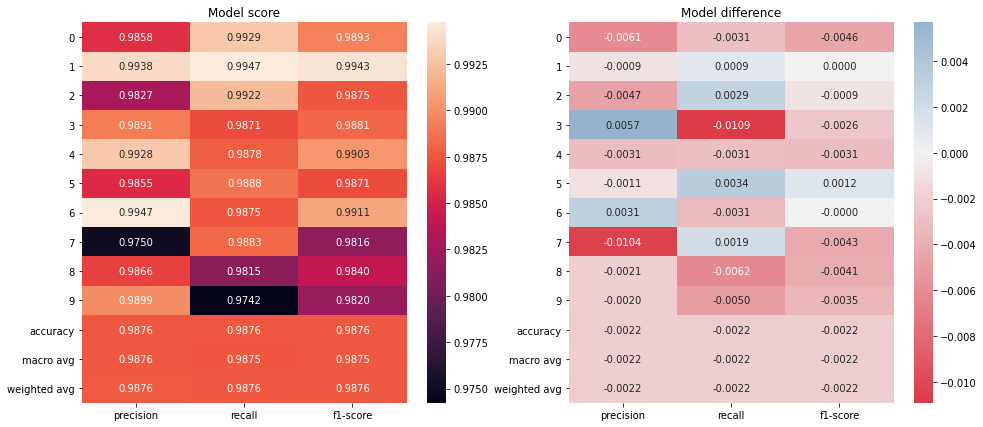

In [32]:
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model4.fit(x_train, y_train, batch_size=512, epochs=10, validation_split=0.1, verbose=0)
evaluate(model4)

Przy zmianie batch size widać zmniejszenie dokładności sieci, jednak nie pokazują się żadne dodatkowe zależności, nawet przy wielokrotnym powtórzeniu eksperymentu.

### Zmiana validation split

c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


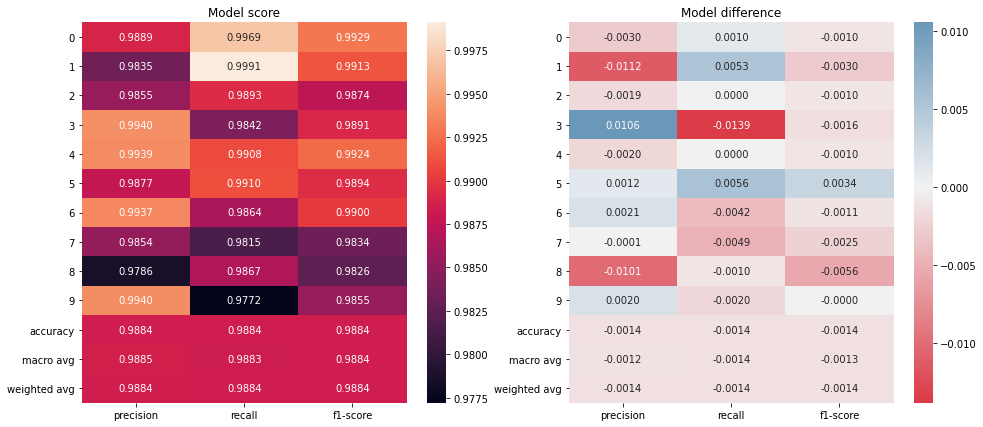

In [29]:
model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model5.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.4, verbose=0)
evaluate(model5)

W przypadku zmiany validation split obserwujemy niewielkie zmniejszenie się jakości sieci, jednak także nie widać żadnych dodatkowych własności.